In [1]:
import sys
sys.path.append("..")

from vizutils import plot_comparison

## PBNN-8-8-8-8

### SILU


Final values (mean ± std):

PBNN (0, 4):
  RMSE: 0.6879 ± 0.0163
  NLPD: 1.0647 ± 0.0232
  COVERAGE: 0.9659 ± 0.0076

PBNN (1, 4):
  RMSE: 0.7391 ± 0.0262
  NLPD: 1.1312 ± 0.0439
  COVERAGE: 0.9187 ± 0.0087

PBNN (2, 4):
  RMSE: 0.7441 ± 0.0141
  NLPD: 1.2116 ± 0.0470
  COVERAGE: 0.8758 ± 0.0145

PBNN (3, 4):
  RMSE: 0.8138 ± 0.0236
  NLPD: 1.3482 ± 0.0258
  COVERAGE: 0.8641 ± 0.0115

Full BNN:
  RMSE: 0.6439 ± 0.0267
  NLPD: 0.9847 ± 0.0283
  COVERAGE: 0.9659 ± 0.0135


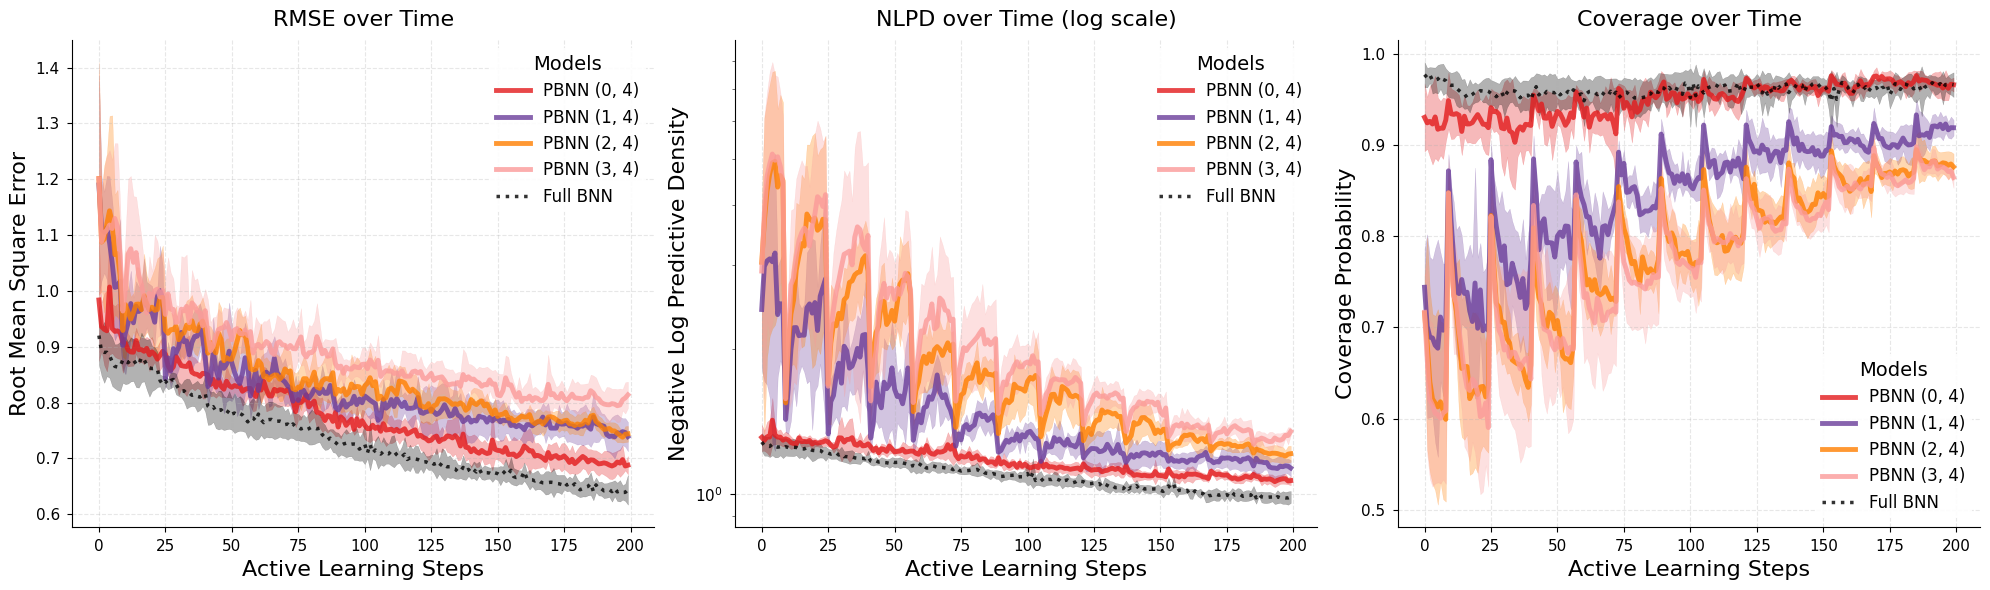

In [2]:
pbnn_files = [
    'results/pbnn8888/esol_probdense0-dense4_steps200_epochs2000_lr0.005_20241207_015431.pkl',
    'results/pbnn8888/esol_probdense1-dense4_steps200_epochs2000_lr0.005_20241207_052815.pkl',
    'results/pbnn8888/esol_probdense2-dense4_steps200_epochs2000_lr0.005_20241207_080057.pkl',
    'results/pbnn8888/esol_probdense3-dense4_steps200_epochs2000_lr0.005_20241206_220527.pkl'
]

#detnn_file = 'results/detnn8888/detnn_silu_epochs2000_lr0.005_20241210_152819.pkl'
bnn_file = 'results/bnn8888/esol_steps200_20241211_194819.pkl'

plot_comparison(
    pbnn_files=pbnn_files,
    bnn_file=bnn_file,
    save_path='comparison_plot-pbnn8888-silu.png'
);

Compare with DKL:


Final values (mean ± std):

PBNN (0, 4):
  RMSE: 0.6879 ± 0.0163
  NLPD: 1.0647 ± 0.0232
  COVERAGE: 0.9659 ± 0.0076

DKL (latent=2, silu):
  RMSE: 0.7986 ± 0.0240
  NLPD: 1.2017 ± 0.0232
  COVERAGE: 0.9597 ± 0.0084


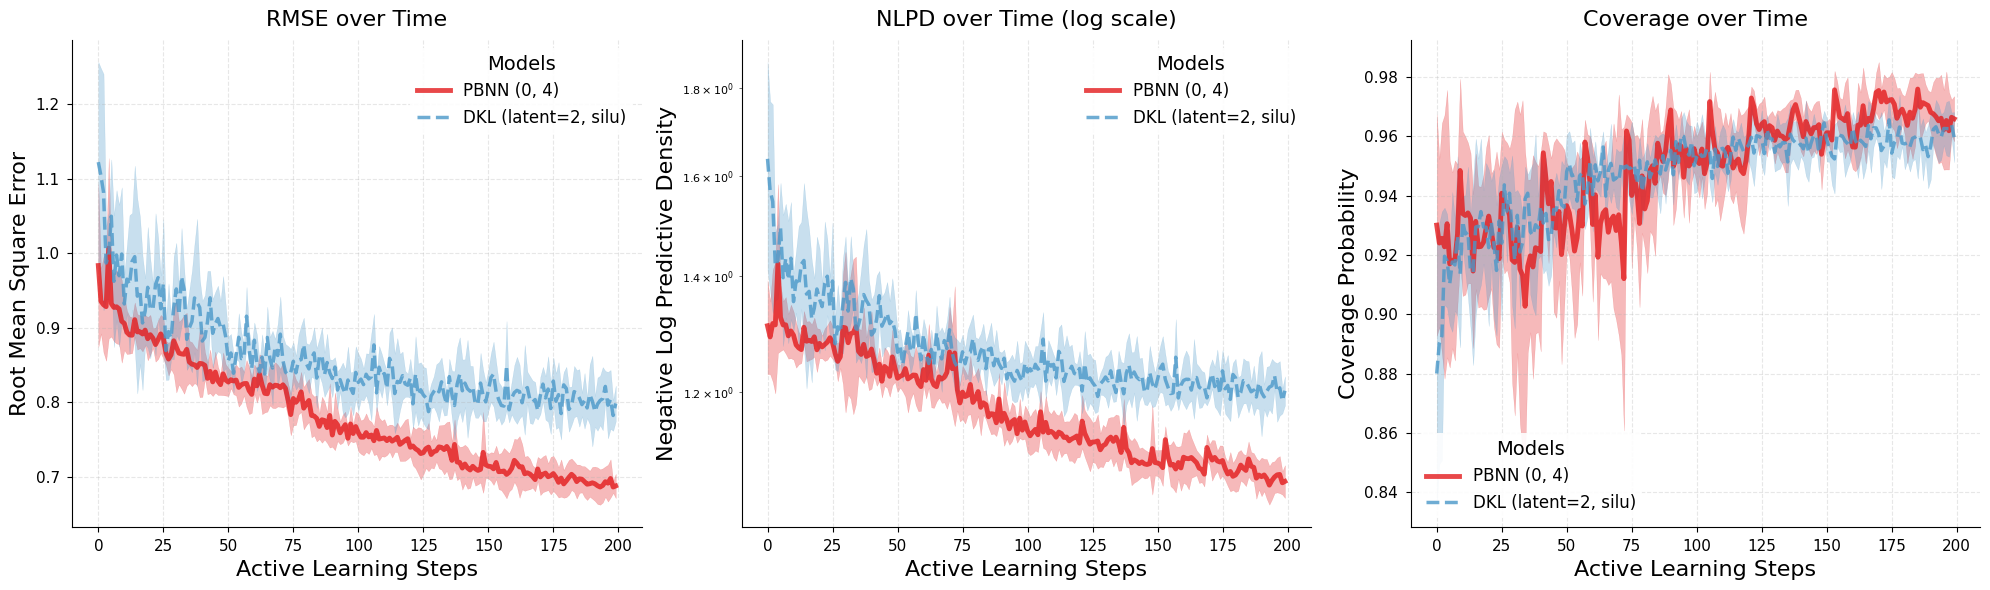

In [4]:
pbnn_files = [
    'results/pbnn8888/esol_probdense0-dense4_steps200_epochs2000_lr0.005_20241207_015431.pkl'
]

dkl_files = [
    'results/dkl8888/esol_dkl_latent2_silu_20241207_132112.pkl'
]

plot_comparison(
    pbnn_files=pbnn_files,
    dkl_files=dkl_files,
    save_path='comparison_plot-dkl-pbnn8888-silu.png'
);

## Tanh

TBA

## PBNN-32-16-8-8

### SILU

Compare results with a single middle hiddle layer (16 neurons) and two last hidden layers (8+8 neurons):


Final values (mean ± std):

PBNN (1, 4):
  RMSE: 0.7097 ± 0.0130
  NLPD: 1.0905 ± 0.0308
  COVERAGE: 0.9194 ± 0.0160

PBNN (2, 3, 4):
  RMSE: 0.7558 ± 0.0217
  NLPD: 1.2595 ± 0.0947
  COVERAGE: 0.8676 ± 0.0287


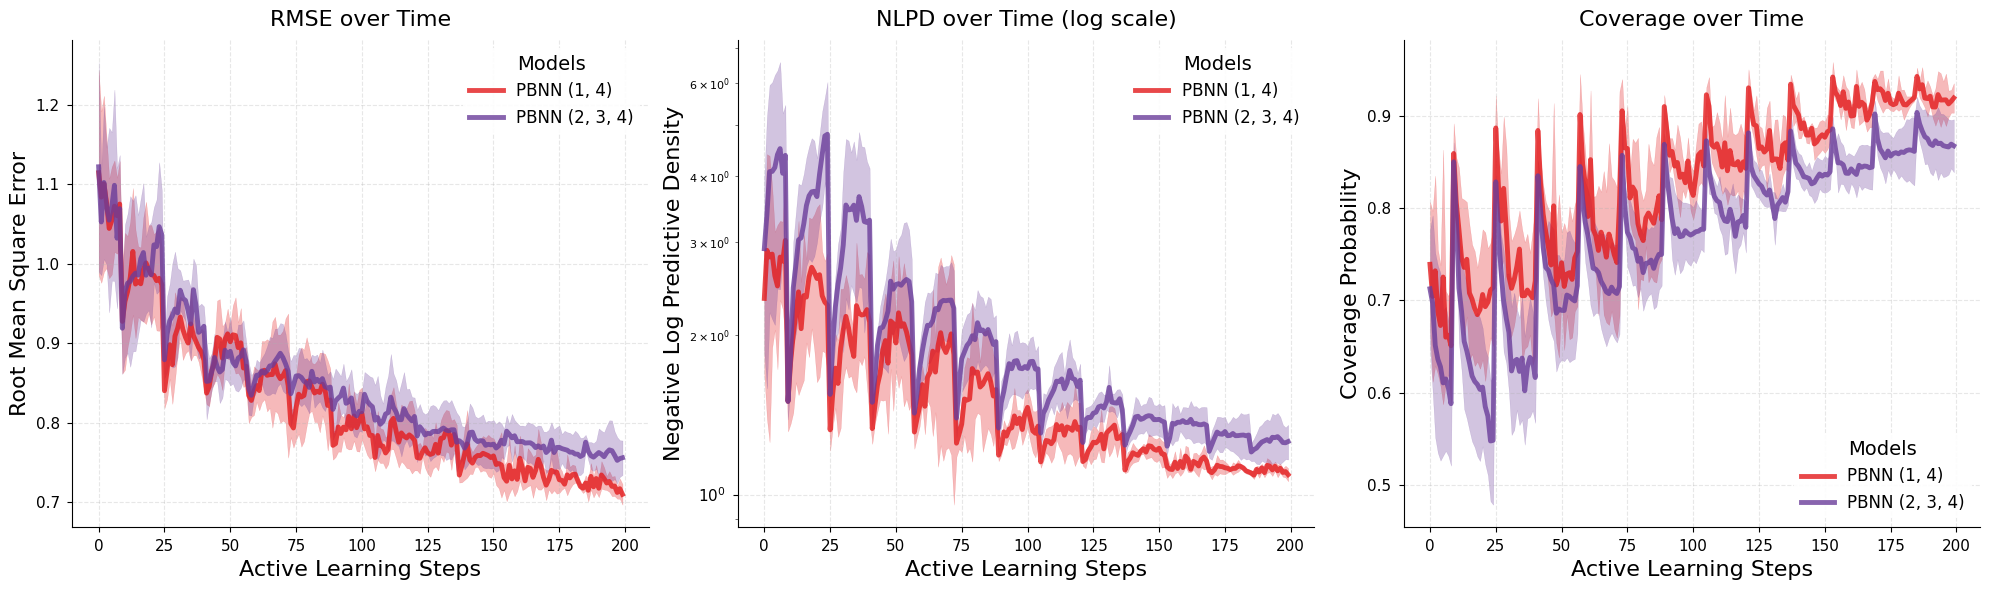

In [5]:
pbnn_files = [
    'results/pbnn321688/esol_probdense1-dense4_steps200_epochs2000_lr0.005_20241202_064817.pkl',
    'results/pbnn321688/esol_probdense2-dense3-dense4_steps200_epochs2000_lr0.005_20241202_132548.pkl'
]


plot_comparison(
    pbnn_files=pbnn_files,
    save_path='comparison_plot-pbnn321688-16neurons-silu.png'
);

Comparison with DKL:


Final values (mean ± std):

PBNN (1, 4):
  RMSE: 0.7097 ± 0.0130
  NLPD: 1.0905 ± 0.0308
  COVERAGE: 0.9194 ± 0.0160

DKL (latent=2, silu):
  RMSE: 0.7717 ± 0.0237
  NLPD: 1.1657 ± 0.0257
  COVERAGE: 0.9553 ± 0.0085


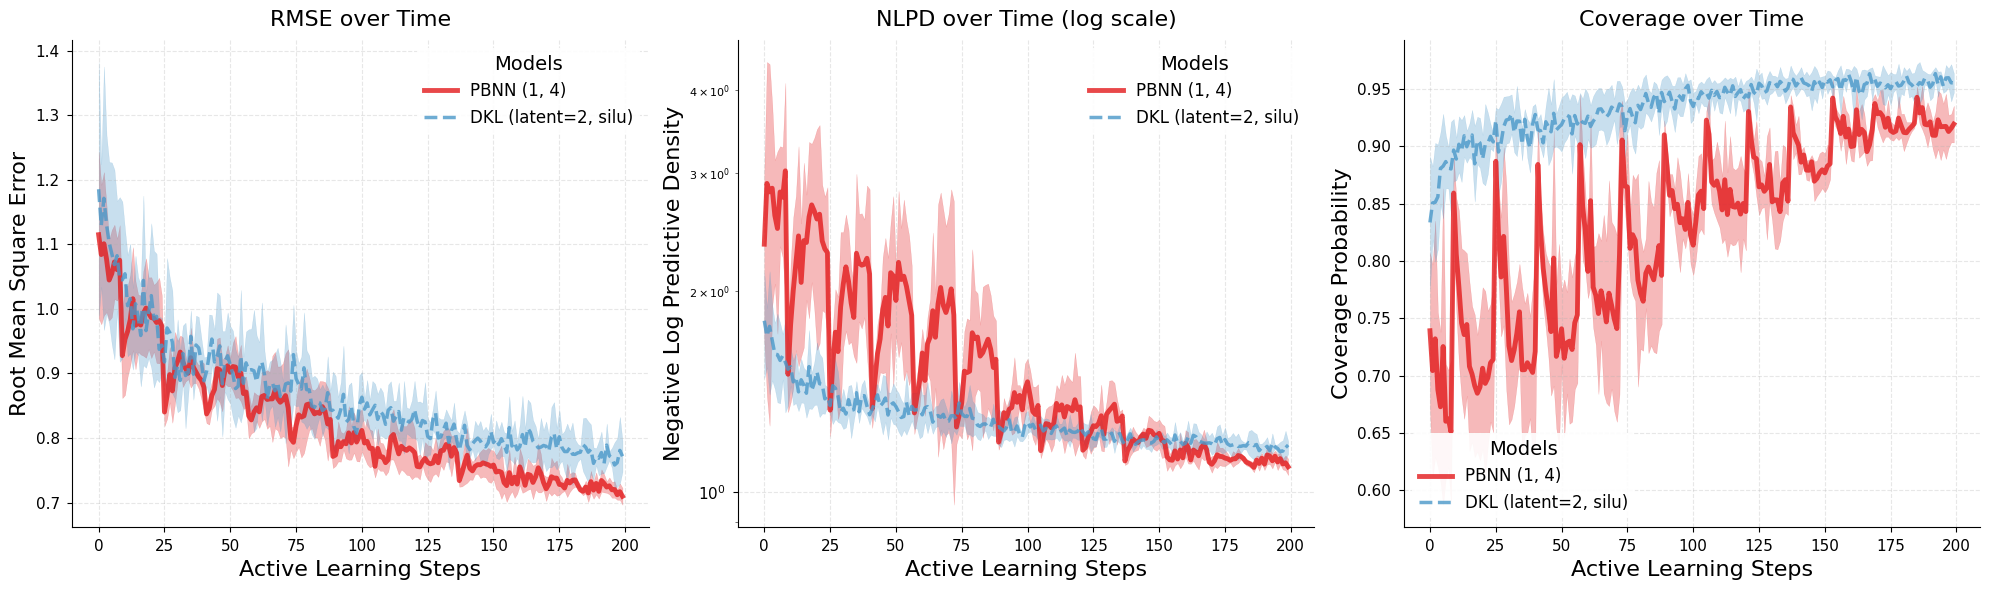

In [6]:
pbnn_files = [
    'results/pbnn321688/esol_probdense1-dense4_steps200_epochs2000_lr0.005_20241202_064817.pkl',
]

dkl_files = [
    'results/dkl321688/esol_dkl_comparison_latent2_silu_20241206_013705.pkl'
]

plot_comparison(
    pbnn_files=pbnn_files,
    dkl_files=dkl_files,
    save_path='comparison_plot-dkl-pbnn321688-silu.png'
);

### Tanh

Compare results with a single middle hiddle layer (16 neurons) and two last hidden layers (8+8 neurons):


Final values (mean ± std):

PBNN (1, 4):
  RMSE: 0.7504 ± 0.0287
  NLPD: 1.1784 ± 0.0785
  COVERAGE: 0.8985 ± 0.0274

PBNN (2, 3, 4):
  RMSE: 0.7535 ± 0.0172
  NLPD: 1.2681 ± 0.0602
  COVERAGE: 0.8687 ± 0.0216


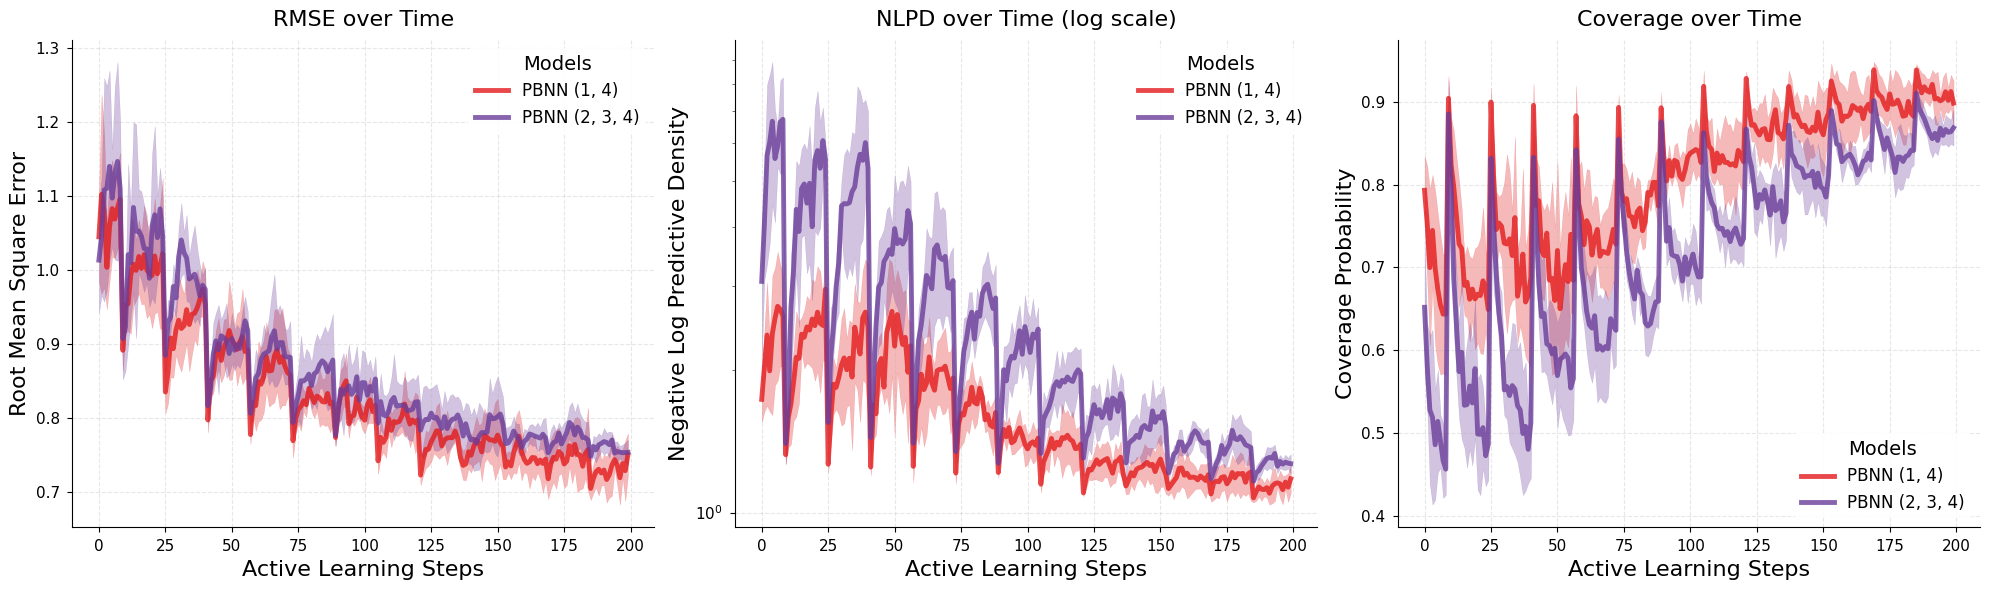

In [7]:
pbnn_files = [
    'results/pbnn321688/esol_probdense1-dense4_steps200_epochs2000_lr0.005_20241201_193626.pkl',
    'results/pbnn321688/esol_probdense2-dense3-dense4_steps200_epochs2000_lr0.005_20241201_073300.pkl'
]

# Create both visualizations
plot_comparison(
    pbnn_files=pbnn_files,
    save_path='comparison_plot-pbnn321688-16neurons-tanh.png'
);

Comparison with DKL:


Final values (mean ± std):

PBNN (1, 4):
  RMSE: 0.7504 ± 0.0287
  NLPD: 1.1784 ± 0.0785
  COVERAGE: 0.8985 ± 0.0274

DKL (latent=2, tanh):
  RMSE: 0.8199 ± 0.0452
  NLPD: 1.2210 ± 0.0555
  COVERAGE: 0.9356 ± 0.0149


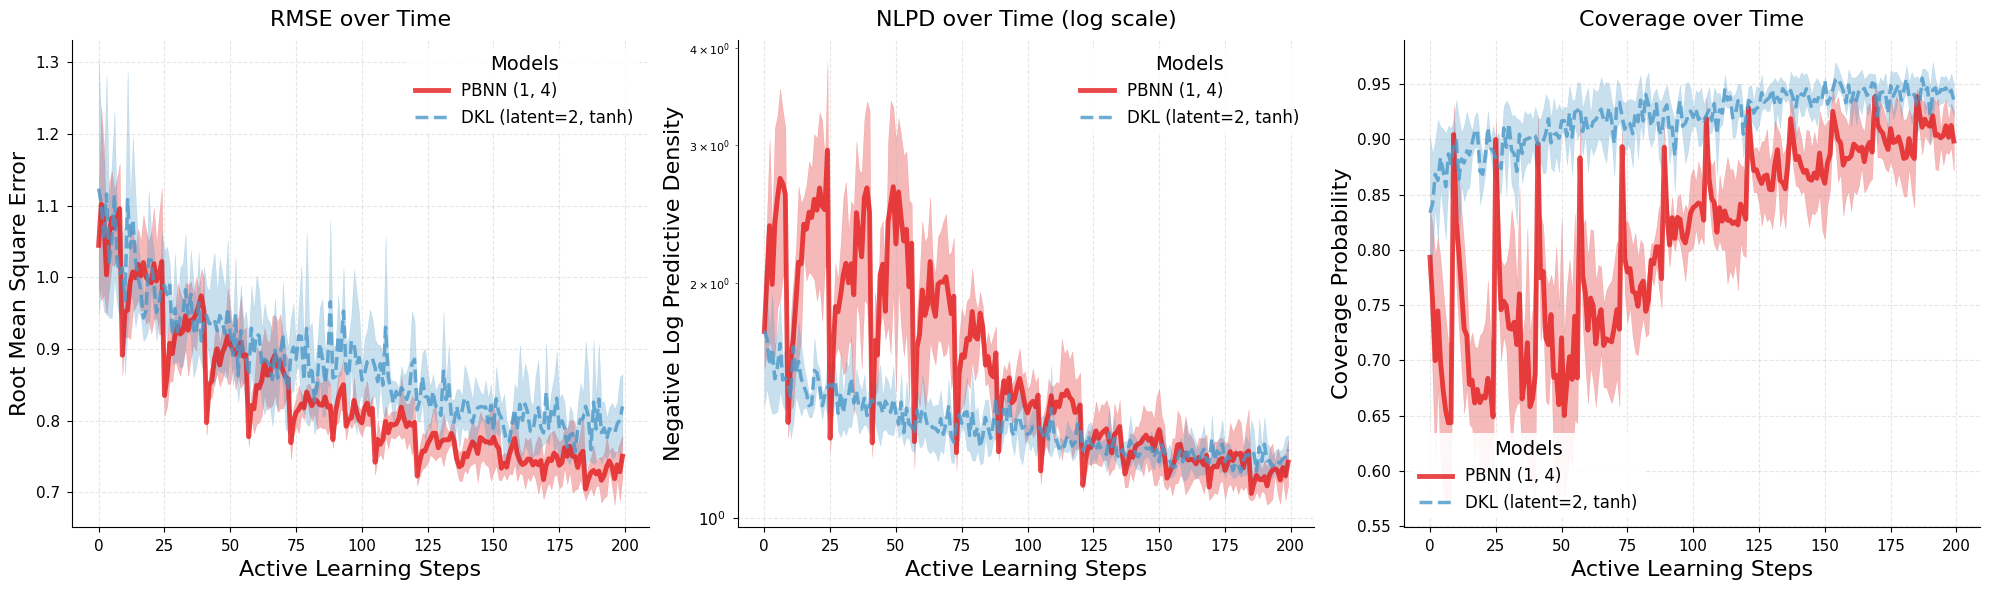

In [8]:
pbnn_files = [
    'results/pbnn321688/esol_probdense1-dense4_steps200_epochs2000_lr0.005_20241201_193626.pkl',
]

dkl_files = [
    'results/dkl321688/esol_dkl_comparison_latent2_tanh_20241206_013348.pkl'
]

plot_comparison(
    pbnn_files=pbnn_files,
    dkl_files=dkl_files,
    save_path='comparison_plot-dkl-pbnn321688-tanh.png'
);